In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [2]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [3]:
#Combine PitchCall KorBB and PlayResult into one column
def combined_columns(event):
    #If there is a value in KorBB return that since PlayResult sometimes does not have KorBB
    if not pd.isna(event['KorBB']):
        return event['KorBB']
    #If the ball is in play in pitchcall we want to return the result to map it
    if event['PitchCall'] == 'InPlay':
        return event['PlayResult']
    #Since we already have if there's a strikeout or if there's an inplay
    else:
        return event['PitchCall']

In [4]:
df['pitch_by_pitch'] = df.apply(combined_columns,axis=1)

In [5]:
mapping_data = pd.read_csv('mean_delta_run_exp_by_outcome_count.csv')

# Map the data: Group by pitch_by_pitch, Balls, and Strikes, and calculate the mean of delta_run_exp_mean
df = df.merge(mapping_data, on=['pitch_by_pitch', 'Balls', 'Strikes'], how='left')

In [6]:
dft = df[['TaggedPitchType','delta_run_exp_mean','Pitcher','VertRelAngle','pitch_by_pitch','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed']]

# Create dummy variables for TaggedPitchType
dummies = pd.get_dummies(dft['TaggedPitchType'], prefix='PitchType',dtype=float)
dft = pd.concat([dft, dummies], axis=1)
pitch_type_dummies = [col for col in dft.columns if col.startswith('PitchType_')]


In [7]:
dft = dft.dropna()

In [8]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter','Curveball','Splitter','Changeup']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [9]:
dft['ff_diff'] = dft.apply(calculate_ff_diff, axis=1)
dft['ivb_diff'] = dft.apply(calculate_ivb_diff, axis=1)
dft['hb_diff'] = dft.apply(calculate_hb_diff, axis=1)
    

In [10]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak','VertRelAngle', 'HorzBreak','VertApprAngle','ZoneSpeed','ff_diff','ivb_diff','hb_diff'] + pitch_type_dummies

In [11]:
required_features = [
    'RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension',
    'InducedVertBreak','VertRelAngle', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed',
    'ff_diff', 'ivb_diff', 'hb_diff'
]

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from scipy.stats import uniform, randint


# Prepare data
X = dft[features]
y = dft['delta_run_exp_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define parameter distribution for RandomizedSearchCV

In [13]:
# Create pipeline
final_model = make_pipeline(
    RobustScaler(),
    XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=0,                  # Set this explicitly
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        gamma=0.0,
        reg_alpha=0.1,
        reg_lambda=0.2,
        tree_method='hist',           # Efficient for large datasets
        random_state=42
    )
)


# Set up RandomizedSearchCV


# Run RandomizedSearchCV
print("\nStarting RandomizedSearchCV Hyperparameter Optimization...")
final_model.fit(X_train, y_train)

# Final model training with best params


# Predictions
y_pred = final_model.predict(X_test)

# Evaluate
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE (RandomizedSearchCV Tuned): {rmse}")

# Optional: Check prediction range
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

# Baseline comparison
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")



Starting RandomizedSearchCV Hyperparameter Optimization...
Test RMSE (RandomizedSearchCV Tuned): 0.1847402630730839
Min Prediction: -0.18910797 Max Prediction: 0.32934982
Mean Prediction: -0.012731219
Baseline RMSE (Mean Prediction): 0.18062342730059466


In [14]:
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")

Baseline RMSE (Mean Prediction): 0.18062342730059466


In [15]:
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

Min Prediction: -0.18910797 Max Prediction: 0.32934982
Mean Prediction: -0.012731219


In [16]:
print("X_train NaN:", y_test.shape)
print("y_train NaN:", y_pred.shape)
print("y_train unique values:", y_train.nunique())

X_train NaN: (4092,)
y_train NaN: (4092,)
y_train unique values: 98


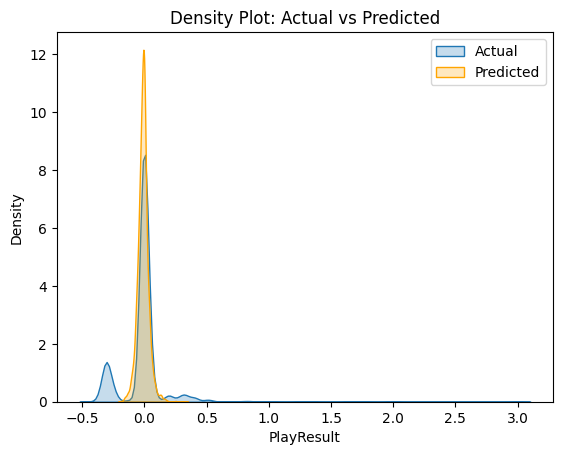

In [17]:
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True, color='orange')
plt.xlabel('PlayResult')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs Predicted')
plt.legend()
plt.show()

In [44]:
y.mean()

np.float64(-0.0158504144282841)

In [45]:
y.median()

np.float64(-0.0021576512766823)

In [50]:
y.std()

np.float64(0.17713484357387707)

In [46]:
import numpy as np
import pandas as pd

# Define the predict_stuff_plus function with dummy variable handling
def predict_stuff_plus(event):
    # Define the full set of features used in training (12 features + pitch type dummies)
    base_features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 
                     'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed', 
                     'ff_diff', 'ivb_diff', 'hb_diff']
    
    
    # Create dummy variables for TaggedPitchType
    if 'TaggedPitchType' in event and not pd.isna(event['TaggedPitchType']):
        dummies = pd.get_dummies(pd.Series(event['TaggedPitchType']), prefix='PitchType', dtype=float)
        input_data.update(dummies.iloc[0].to_dict())
    else:
        return np.nan  # Missing TaggedPitchType
    
    # Convert to DataFrame and align with training columns
    input_df = pd.DataFrame([input_data])
    
    # Get the feature names from the trained model (assuming pipeline with RobustScaler and XGBRegressor)
    feature_names = final_model.named_steps['xgbregressor'].get_booster().feature_names
    if feature_names is None:
        # Fallback: Use the columns from X_train if available (you may need to pass X_train columns)
        feature_names = X_train.columns  # Ensure X_train is defined in the scope
    
    # Reindex input_df to match the expected feature order and fill missing columns with 0
    input_df = input_df.reindex(columns=feature_names, fill_value=0)
    
    # Predict using the trained model
    pred = final_model.predict(input_df)[0]
    
    # Apply inverse sigmoid transformation to compress to (0, 1), where higher pred -> lower Stuff+
    k = 50  # Steepness parameter (adjusted for xRV range)
    xrv_mean = y.mean() if hasattr(y, 'mean') else 0.28  # Fallback to approximate xRV mean
    sigmoid = 1 / (1 + np.exp(k * (pred - xrv_mean)))  # Inverted logic
    
    # Scale to 50-150 (lower pred -> higher Stuff+, higher pred -> lower Stuff+)
    scaled_pred = 50 + (150 - 50) * sigmoid
    
    return scaled_pred

# Use the entire dataset
df_all = df.copy()

## Stuff+ Calculation ##
# Calculate the mean and standard deviation of delta_run_exp_mean for the entire dataset
target_mean = df_all['delta_run_exp_mean'].mean()
target_std = df_all['delta_run_exp_mean'].std()

# Standardize the delta_run_exp_mean column to create a z-score
df_all['target_zscore'] = (df_all['delta_run_exp_mean'] - target_mean) / target_std

# Convert the z-score to Stuff+ (100 - zscore * 10)
df_all['stuff_plus'] = 100 - (df_all['target_zscore'] * 10)

# Aggregate Stuff+ by pitcher_id
df_agg = df_all.groupby(['Pitcher']).agg(
    count=('stuff_plus', 'size'),
    mean_stuff_plus=('stuff_plus', 'mean')
).reset_index()

# Apply predict_stuff_plus to get model-based Stuff+
df_all['predicted_stuff_plus'] = df_all.apply(predict_stuff_plus, axis=1)

# Display results
print("Aggregated Stuff+ by Pitcher:")
print(df_agg)

print("\nSample of Data with Predicted Stuff+:")
print(df_all[['Pitcher', 'delta_run_exp_mean', 'stuff_plus', 'predicted_stuff_plus']].head())


NameError: name 'input_data' is not defined

In [ ]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [ ]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [ ]:
kcl_df['ff_diff'] = kcl_df.apply(calculate_ff_diff, axis=1)
kcl_df['ivb_diff'] = kcl_df.apply(calculate_ivb_diff, axis=1)
kcl_df['hb_diff'] = kcl_df.apply(calculate_hb_diff, axis=1)
cornbelters_df['ff_diff'] = cornbelters_df.apply(calculate_ff_diff, axis=1)
cornbelters_df['ivb_diff'] = cornbelters_df.apply(calculate_ivb_diff, axis=1)
cornbelters_df['hb_diff'] = cornbelters_df.apply(calculate_hb_diff, axis=1)

In [ ]:
kcl_df['Stuff+'] = kcl_df.apply(predict_stuff_plus,axis=1)
cornbelters_df['Stuff+'] = cornbelters_df.apply(predict_stuff_plus,axis=1)

In [ ]:
pitcher_stuffplus = kcl_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
pitcher_stuffplus.to_csv('stuff+.csv')
cornbelters_stuffplus = cornbelters_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
cornbelters_stuffplus.to_csv('cb.csv')

In [47]:
import pickle

In [48]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(final_model, f)